# Titanic's passengers

* In this competition we have data about Titanic's passengers. The data is divided into two files: train and test. In "train" file a column "Survival" shows whether the passenger survived or not.
* At first I explore the data, modify it and create some new features, then I select the most important of them and make a prediction using Random Forest.
* Reference: https://www.kaggle.com/c/titanic

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel

## 01- Data exploration

In [2]:
# Age is read as float type, because later I'll need more precision for calculations.
df_train = pd.read_csv('input/train.csv', dtype={'Age': np.float64}, )
df_test = pd.read_csv('input/test.csv', dtype={'Age': np.float64}, )

In [3]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Sobey, Mr. Samuel James Hayden",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [4]:
df_test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Brown, Miss. Edith Eileen",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### 1.1- Variable: PClass

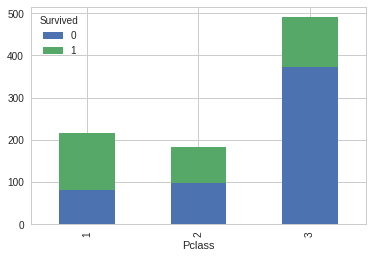

In [6]:
df_train.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)

* Pclass: It seems that Pclass is useful and requires no changes. Passengers with Pclass 3 have less chances for survival. This is reasonable, as passengers with more expensive tickets lived at higher decks and thus could get to lifeboats faster.

### 1.2- Variable: Name


* Names: by themselves are useful. One way to use them is grouping people by family names - maybe families have better chance for survival? But it is complicated, and there is a better way to create a feature for families. Another way is extracting a title from the name and using it. Let's try.


In [7]:
df_train['Title'] = df_train['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))
df_test['Title'] = df_test['Name'].apply(lambda x: (re.search(' ([a-zA-Z]+)\.', x)).group(1))

df_train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Mme           1
Sir           1
Jonkheer      1
Lady          1
Capt          1
Countess      1
Ms            1
Don           1
Name: Title, dtype: int64

* There are many titles, in fact it is a bad idea to use them as they are - I tried and the accuracy got worse. A good idea is grouping them by social status or something like that. I have found several ways to group them. Here is the one I chose.

In [8]:
titles = {'Capt': 'Officer',
          'Col': 'Officer',
          'Major': 'Officer',
          'Jonkheer': 'Royalty',
          'Don': 'Royalty',
          'Sir': 'Royalty',
          'Dr': 'Officer',
          'Rev': 'Officer',
          'Countess': 'Royalty',
          'Dona': 'Royalty',
          'Mme': 'Mrs',
          'Mlle': 'Miss',
          'Ms': 'Mrs',
          'Mr': 'Mr',
          'Mrs': 'Mrs',
          'Miss': 'Miss',
          'Master': 'Master',
          'Lady': 'Royalty'
          } 

for k,v in titles.items():
    df_train.loc[df_train['Title'] == k, 'Title'] = v
    df_test.loc[df_test['Title'] == k, 'Title'] = v

#New frequencies.
df_train['Title'].value_counts()

Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: Title, dtype: int64

### 1.3 - Variable: Age

* Missing values for Age should be filled. I think that simple mean/median isn't good enough. So I tried several ways to group other columns and chose median by Sex, Pclass and Title.

In [9]:
print(df_train.groupby(['Sex', 'Pclass', 'Title'])['Age'].median())

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        40.0
                Officer    49.0
                Royalty    40.5
        2       Miss       24.0
                Mrs        31.5
        3       Miss       18.0
                Mrs        31.0
male    1       Master      4.0
                Mr         40.0
                Officer    51.0
                Royalty    40.0
        2       Master      1.0
                Mr         31.0
                Officer    46.5
        3       Master      4.0
                Mr         26.0
Name: Age, dtype: float64


In [10]:
df_train['Age'] = df_train.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))
df_test['Age'] = df_test.groupby(['Sex','Pclass','Title'])['Age'].apply(lambda x: x.fillna(x.median()))

### 1.4 - Variable: Sex

* At first I wanted to divide passengers into males, females and children, but it increased overfitting. Also I tried to replace values with 1 and 0 (instead of creating dummies), it also worked worse. So doing nothing here.


In [11]:
df_train.groupby(['Pclass', 'Sex'])['Survived'].value_counts(normalize=True)

Pclass  Sex     Survived
1       female  1           0.968085
                0           0.031915
        male    0           0.631148
                1           0.368852
2       female  1           0.921053
                0           0.078947
        male    0           0.842593
                1           0.157407
3       female  0           0.500000
                1           0.500000
        male    0           0.864553
                1           0.135447
Name: Survived, dtype: float64

### 1.5 - Variable: SibSp and Parch

* Number of Siblings/Spouses and Parents/Children Aboard. Basically - amount of family members. So if we sum them, we get the size of the family. At first I created a single feature showing whether the person had family. It wasn't good enough. Then I tried several variants and stopped on four groups: 0 relatives, 1-2, 3 and 5 or more. From the table below we can see that such grouping makes sense.

In [12]:
df_train['Family'] = df_train['Parch'] + df_train['SibSp']
df_test['Family'] = df_test['Parch'] + df_test['SibSp']

In [13]:
df_train.groupby(['Family'])['Survived'].value_counts(normalize=True)

Family  Survived
0       0           0.696462
        1           0.303538
1       1           0.552795
        0           0.447205
2       1           0.578431
        0           0.421569
3       1           0.724138
        0           0.275862
4       0           0.800000
        1           0.200000
5       0           0.863636
        1           0.136364
6       0           0.666667
        1           0.333333
7       0           1.000000
10      0           1.000000
Name: Survived, dtype: float64

In [14]:
def FamilySize(x):
    """
    A function for Family size transformation
    """
    if x == 1 or x == 2:
        return 'little'
    elif x == 3:
        return 'medium'
    elif x >= 5:
        return 'big'
    else:
        return 'single'

df_train['Family'] = df_train['Family'].apply(lambda x : FamilySize(x))
df_test['Family'] = df_test['Family'].apply(lambda x : FamilySize(x))

In [15]:
df_train.groupby(['Pclass', 'Family'])['Survived'].mean()

Pclass  Family
1       big       0.500000
        little    0.734043
        medium    0.714286
        single    0.540541
2       big       1.000000
        little    0.600000
        medium    0.769231
        single    0.352381
3       big       0.095238
        little    0.384615
        medium    0.666667
        single    0.205357
Name: Survived, dtype: float64

### 1.6 - Variable: Ticket

* This value can't be used by itself. Ticket contains prefix and number. Using ticket number doesn't make sense, but prefix could be useful.

In [16]:
def Ticket_Prefix(x):
    """
    Function for extracting prefixes. Tickets have length of 1-3.
    """
    l = x.split()
    if len(x.split()) == 3:
        return x.split()[0] + x.split()[1]
    elif len(x.split()) == 2:
        return x.split()[0]
    else:
        return 'None'

df_train['TicketPrefix'] = df_train['Ticket'].apply(lambda x: Ticket_Prefix(x))
df_test['TicketPrefix'] = df_test['Ticket'].apply(lambda x: Ticket_Prefix(x))

In [17]:
#There are many similar prefixes, but combining them doesn't yield a significantly better result.
df_train.TicketPrefix.unique()

array(['A/5', 'PC', 'STON/O2.', 'None', 'PP', 'A/5.', 'C.A.', 'A./5.',
       'SC/Paris', 'S.C./A.4.', 'A/4.', 'CA', 'S.P.', 'S.O.C.', 'SO/C',
       'W./C.', 'SOTON/OQ', 'W.E.P.', 'A4.', 'C', 'SOTON/O.Q.', 'SC/PARIS',
       'S.O.P.', 'A.5.', 'Fa', 'CA.', 'F.C.C.', 'W/C', 'SW/PP', 'SCO/W',
       'P/PP', 'SC', 'SC/AH', 'A/S', 'SC/AHBasle', 'A/4', 'WE/P',
       'S.W./PP', 'S.O./P.P.', 'F.C.', 'SOTON/O2', 'S.C./PARIS',
       'C.A./SOTON'], dtype=object)

### 1.7 - Variable: Fare

* There is only one missing value, and in test. Fill it with median for its Pclass.

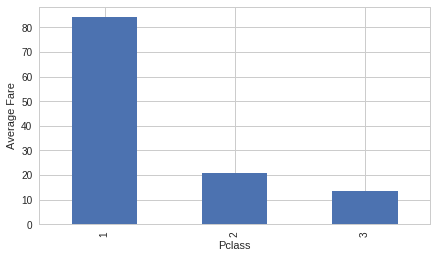

In [18]:
ax = plt.subplot()
ax.set_ylabel('Average Fare')
df_train.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(7, 4), ax=ax)
df_test['Fare'] = df_test.groupby(['Pclass'])['Fare'].apply(lambda x: x.fillna(x.median()))

### 1.8 - Variable: Cabin

* I thought about ignoring this feature, but it turned out to be quite significant. And the most important for predicting was whether there was information about the Cabin or not. So I fill NA with 'Unknown" value and use the first letter of the Cabin number as a feature.

In [19]:
df_train.Cabin.fillna('Unknown',inplace=True)
df_test.Cabin.fillna('Unknown',inplace=True)

df_train['Cabin'] = df_train['Cabin'].map(lambda x: x[0])
df_test['Cabin'] = df_test['Cabin'].map(lambda x: x[0])

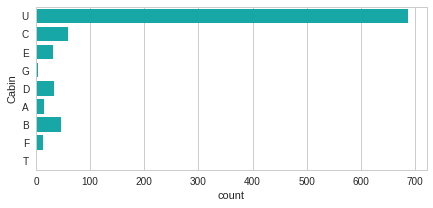

In [20]:
#Now let's see. Most of the cabins aren't filled.
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y='Cabin', data=df_train, color='c')

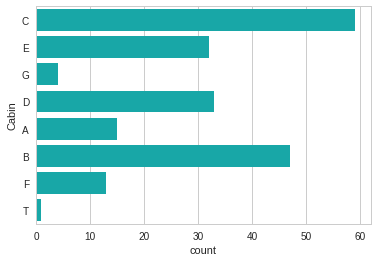

In [21]:
#Other cabins vary in number.
sns.countplot(y='Cabin', data=df_train[df_train.Cabin != 'U'], color='c')

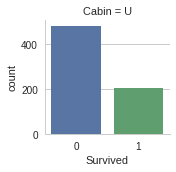

In [22]:
#Factorplot shows that most people, for whom there is no info on Cabin, didn't survive.
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=df_train[df_train.Cabin == 'U'], kind='count', size=2.5, aspect=.8)

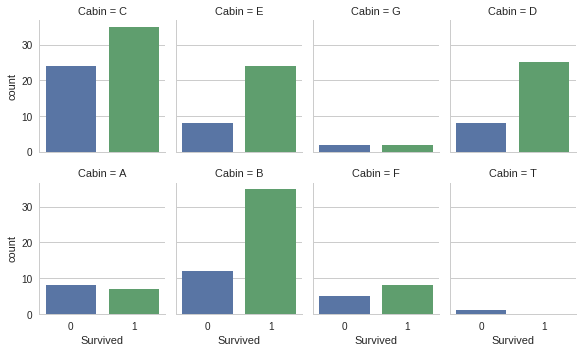

In [23]:
#For passengers with known Cabins survival rate varies.
sns.factorplot('Survived', col='Cabin', col_wrap=4, data=df_train[df_train.Cabin != 'U'], kind='count', size=2.5, aspect=.8)

In [24]:
df_train.groupby(['Cabin']).mean()[df_train.groupby(['Cabin']).mean().columns[1:2]]

,Survived
Cabin,
A,0.466667
B,0.744681
C,0.593220
D,0.757576
E,0.750000
F,0.615385
G,0.500000
T,0.000000
U,0.299854


### 1.9 Variable: Embarked

In [25]:
MedEmbarked = df_train.groupby('Embarked').count()['PassengerId']
df_train.Embarked.fillna(MedEmbarked, inplace=True)

## 02- Data preparation

In [26]:
#This is how the data looks like now.
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Family,TicketPrefix
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,little,A/5
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,little,PC
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,single,STON/O2.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,little,None
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,single,None
